In [1]:
%pylab inline
import cv2
import numpy as np
import pydicom as dicom
import pandas as pd
import sys, os
from pathlib import Path

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
%matplotlib inline


Bad key savefig.frameon in file /home/frfa/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 421 ('savefig.frameon : True')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.4.3/matplotlibrc.template
or from the matplotlib source distribution

Bad key verbose.level in file /home/frfa/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 472 ('verbose.level  : silent      # one of silent, helpful, debug, debug-annoying')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.4.3/matplotlibrc.template
or from the matplotlib source distribution

Bad key verbose.fileo in file /home/frfa/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 473 ('verbose.fileo  : sys.stdout  # a log filename, sys.stdout or sys.stderr')
You probably need to get an update

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Inserting siebling folder to sys. Ensures other code can be ran
# Note: Must have end2end-all-conv folder in the parent of the current folder
github_path = "../../end2end-all-conv"
sys.path.insert(1, os.path.abspath(github_path))

In [3]:
from dm_image import get_prob_heatmap
from dm_image import read_resize_img
import keras
from keras.models import load_model

Using TensorFlow backend.
/home/frfa/anaconda3/lib/python3.7/site-packages/dask/dataframe/utils.py:14: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [119]:
# Define arguments
img_list = "../../data/cbis-ddsm/all_test_img/Mass-Test_P_00576_LEFT_MLO.png"
target_height = 896
target_scale = 255
patch_size = 256 #224
stride = 32
roi_model = load_model('../../end2end-all-conv/trained_models/ddsm_patch_state/s30_vgg19.h5')
batch_size = 1

In [18]:
import cv2
import numpy as np
import pydicom 
import pathlib
import scipy as sp
import scipy.ndimage

# Inserting parent folder in sys, to allow imports
sys.path.append("..")
from load_preprocess.load_meta import get_cbis_test

In [6]:
# Get ROI meta
roi_meta = get_cbis_test(whole_image_labels=False)

In [47]:
def color_roi(img_path, roi_paths, roi_labels):
    # Reading img
    img_ds = pydicom.dcmread(img_path)
    img_arr = img_ds.pixel_array / 65535 # Pixel array, normalized
    gray_3_channel = cv2.merge((img_arr,img_arr,img_arr)) # Convert grayscale to color
    gray_3_channel_base = cv2.merge((img_arr,img_arr,img_arr)) # Convert grayscale to color
    
    for i in range(len(roi_paths)):
        roi_ds = pydicom.dcmread(roi_paths[i])
        roi_arr = roi_ds.pixel_array
        
        # Mask image on ROI, color based on label
        if roi_labels[i] == 1:
            colors = (1, 0, 0)
        else:
            colors = (0, 1, 0)
        gray_3_channel[roi_arr==255] = colors
        
        result = cv2.addWeighted(gray_3_channel_base, 0.5, gray_3_channel, 0.5, 0.0)
        
    # Resize final image
    target_height, target_width = (1152, 896)
    if (target_height, target_width) != result.shape:
        result = cv2.resize(
            result, dsize=(target_width, target_height), 
            interpolation=cv2.INTER_CUBIC)
    result = result.astype('float32')
        
    # Display image with heatmap
    plt.rcParams["figure.figsize"] = [16,9]
    plt.axis('off')
    f = plt.imshow( result )
    plt.show()
    
    #return result

In [37]:
def get_input(subject_id):
    tmp_meta = roi_meta[roi_meta["Subject ID"] == subject_id]
    
    # Get the whole image path
    old_file_location = tmp_meta["File Location"].iloc[0]
    img_basepath = "../../data/cbis-ddsm/manifest-ZkhPvrLo5216730872708713142"
    path = pathlib.PureWindowsPath(old_file_location)
    path = img_basepath / path / "1-1.dcm"
    img_path = pathlib.PurePosixPath(path)
    
    # Get each ROI
    rois, labels = [], []
    for index, row in tmp_meta.iterrows():
        # Get ROI path
        roi = row["ROI mask file path"]
        tmp_roi = [x[0] for x in os.walk(
            "../../data/cbis-ddsm/manifest-ZkhPvrLo5216730872708713142/CBIS-DDSM/" + roi.split("/")[0]
        )][-1] + "/1-2.dcm"
        rois.append(tmp_roi)
        
        # Get associated ROI label
        if row["pathology"] == "MALIGNANT":
            label = 1
        else:
            label = 0
        labels.append(label)
        
    return img_path, rois, labels

In [109]:
# Get false positives and true false negatives of predictions

results_df = pd.read_csv("../../data/cbis-ddsm/results/end2end_cbis_test_results.csv")
results_df["Subject ID"] = results_df["Filename"].str.split("/").str[1].str.split(".").str[0]

feature_df = pd.read_csv("../../data/cbis-ddsm/meta/cbis_test_with_features.csv")
results_df = results_df.merge(feature_df, on="Subject ID")

fp_df = results_df[
    (results_df["hybrid_pred_pos_aug"] > 0.5) & (results_df["true_neg"] == 1.0)
]

fn_df = results_df[
    (results_df["hybrid_pred_neg_aug"] > 0.5) & (results_df["true_pos"] == 1.0)
]

fp_df_text = fp_df[fp_df["feature_text"] == 1]
fp_df_nipple = fp_df[fp_df["feature_nipple_dot"] == 1]
fp_df_scar = fp_df[fp_df["feature_scar_line"] == 1]
fp_df_ruler = fp_df[fp_df["feature_ruler"] == 1]

fn_df_text = fn_df[fn_df["feature_text"] == 1]
fn_df_nipple = fn_df[fn_df["feature_nipple_dot"] == 1]
fn_df_scar = fn_df[fn_df["feature_scar_line"] == 1]
fn_df_ruler = fn_df[fn_df["feature_ruler"] == 1]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


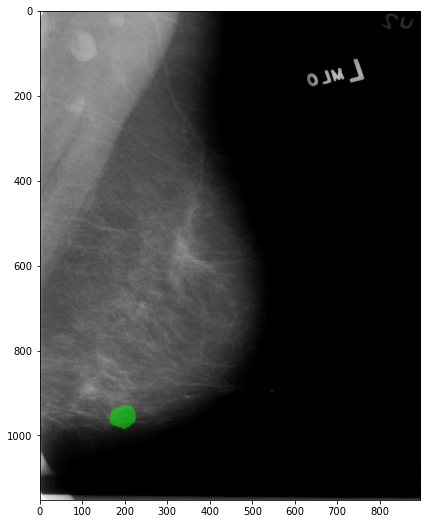

In [39]:
# Example - Color ROIs of first image in False Positives list
img_path, roi_paths, roi_labels = get_input(fp_df["Subject ID"].iloc[0])
color_roi(img_path, roi_paths, roi_labels)

In [121]:
def get_heatmap(subject_id):
    img = "../../data/cbis-ddsm/all_test_img/" + subject_id + ".png"
    
    resized_img = read_resize_img(img, target_size=(1152, 896), target_scale=target_scale) #rescale_factor=0.003891,
    
    heatmap_list, preprocessed_img, original_img = get_prob_heatmap(
        img_list = resized_img, # img
        target_height = target_height,
        target_scale = target_scale,
        patch_size = patch_size,
        stride = stride,
        model = roi_model,
        batch_size = batch_size
    )
    
    # sweep variables
    nb_row = round(float(preprocessed_img.shape[0] - patch_size)/stride + .49)
    nb_col = round(float(preprocessed_img.shape[1] - patch_size)/stride + .49)
    nb_row = int(nb_row)
    nb_col = int(nb_col)
    sweep_hei = patch_size + (nb_row - 1)*stride
    sweep_wid = patch_size + (nb_col - 1)*stride
    y_gap = int((preprocessed_img.shape[0] - sweep_hei)/2)
    x_gap = int((preprocessed_img.shape[1] - sweep_wid)/2)
    
    # Scale and crop image to fit sweeps
    preprocessed_img = preprocessed_img[
        int(patch_size / 2 - x_gap):int(preprocessed_img.shape[0] - patch_size/2 + x_gap),
        int(patch_size / 2 - y_gap):int(preprocessed_img.shape[1] - patch_size/2 + y_gap)
    ] / 225
    
    # Iterate through each heatmap - except the background
    for i in range(5):
        
        # Current heatmap
        heatmap = heatmap_list[:,:,i]
    
        # Scale heatmap to fit image
        n = round(preprocessed_img.shape[1]/nb_col)
        scaled_heatmap = np.kron(heatmap, np.ones((n,n)))
        #print("img shape, heatmap shape:", preprocessed_img.shape, scaled_heatmap.shape)

        if scaled_heatmap.shape[0] < preprocessed_img.shape[0]:
            N = scaled_heatmap.shape[1]
            M = preprocessed_img.shape[0]-scaled_heatmap.shape[0]
            for j in range(M):
                if j % 2 == 0:
                    scaled_heatmap = np.r_[ scaled_heatmap, np.zeros((1,N)) ]
                else:
                    scaled_heatmap = np.r_[ np.zeros((1,N)), scaled_heatmap ]
        if scaled_heatmap.shape[1] < preprocessed_img.shape[1]:
            N = scaled_heatmap.shape[0]
            M = preprocessed_img.shape[1]-scaled_heatmap.shape[1]
            for j in range(M):
                if j % 2 == 0:
                    scaled_heatmap = np.c_[ scaled_heatmap, np.zeros((N,1)) ]
                else:
                    scaled_heatmap = np.c_[ np.zeros((N,1)), scaled_heatmap ]
        if scaled_heatmap.shape[0] > preprocessed_img.shape[0]:
            N = preprocessed_img.shape[1]
            M = scaled_heatmap.shape[0]-preprocessed_img.shape[0]
            for j in range(M):
                if j % 2 == 0:
                    print((N, scaled_heatmap.shape))
                    preprocessed_img = np.r_[ preprocessed_img, np.zeros((1,N)) ]
                else:
                    preprocessed_img = np.r_[ np.zeros((1,N)), preprocessed_img ]
        if scaled_heatmap.shape[1] > preprocessed_img.shape[1]:
            N = preprocessed_img.shape[0]
            M = scaled_heatmap.shape[1]-preprocessed_img.shape[1]
            for j in range(M):
                if j % 2 == 0:
                    preprocessed_img = np.c_[ preprocessed_img, np.zeros((N,1)) ]
                else:
                    preprocessed_img = np.c_[ np.zeros((N,1)), preprocessed_img ]
                    
        # Gaussian filter - smoothens patch heatmap
        sigma_y = 10
        sigma_x = 10
        sigma = [sigma_y, sigma_x]
        scaled_heatmap = sp.ndimage.filters.gaussian_filter(scaled_heatmap, sigma, mode='constant')

        # Make image and heatmap RBG format (heatmap color pure red or green, depending on class)
        rgb_img = cv2.cvtColor(preprocessed_img.astype('float32'), cv2.COLOR_GRAY2RGB) # Convert gray to RBG
        heatmap_dim = np.zeros((scaled_heatmap.shape[0], scaled_heatmap.shape[1])).astype('float32') # Convert gray to RBG
        
        if i == 0: # Background
            rbg_heatmap = cv2.merge((heatmap_dim, heatmap_dim, scaled_heatmap.astype('float32')))
        elif i==1 or i==3: # Malignant
            rbg_heatmap = cv2.merge((heatmap_dim, scaled_heatmap.astype('float32'), heatmap_dim))
        else: # Benign
            rbg_heatmap = cv2.merge((scaled_heatmap.astype('float32'),heatmap_dim, heatmap_dim))

        
        # Probability threshold
        #rbg_heatmap[rbg_heatmap < 0.8] = 0
        
        # Mix image and heatmap
        result = cv2.addWeighted(rgb_img, 1, rbg_heatmap, 0.5, 0.0)

        # Display image with heatmap
        plt.rcParams["figure.figsize"] = [16,9]
        plt.axis('off')
        f = plt.imshow( result )
        plt.show()
        
    # Add true ROI image
    img_path, roi_paths, roi_labels = get_input(subject_id)
    color_roi(img_path, roi_paths, roi_labels)
    


Calc-Test_P_02153_RIGHT_CC
(928, (1188, 928))
(928, (1188, 928))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


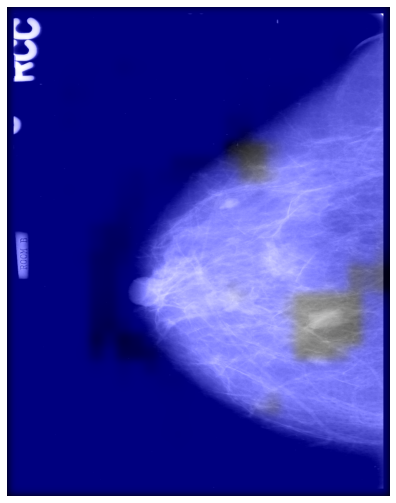

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


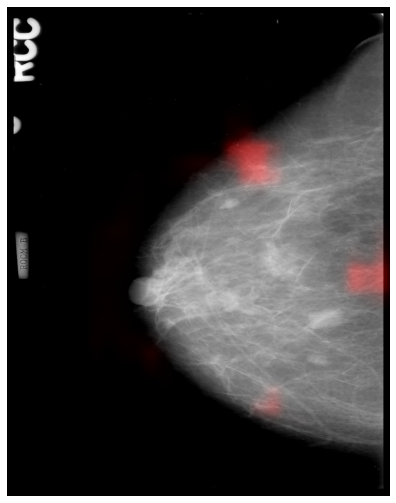

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


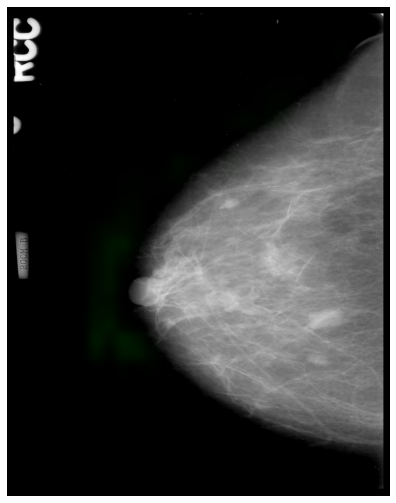

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


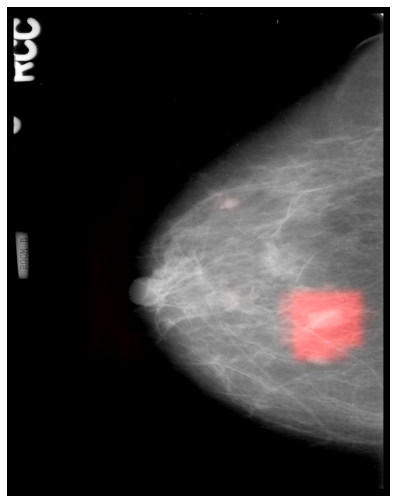

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


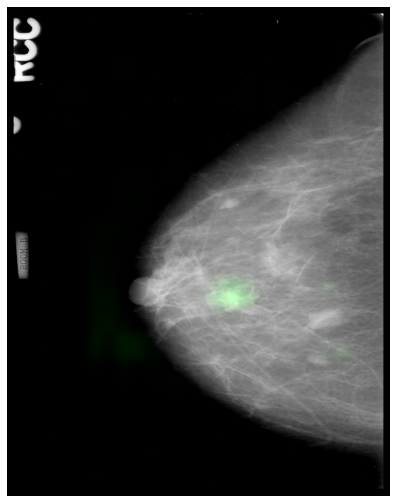

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


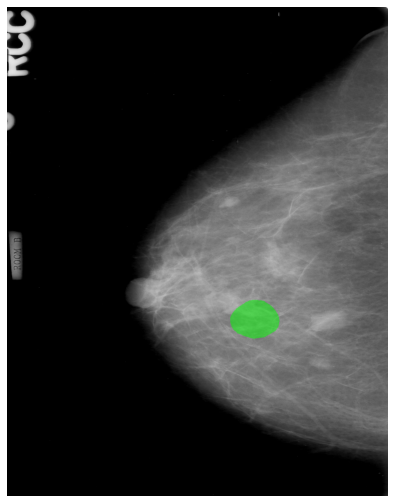

In [120]:
subject_id = fp_df_text["Subject ID"].iloc[31]
print(subject_id)
get_heatmap(subject_id)

# False positives

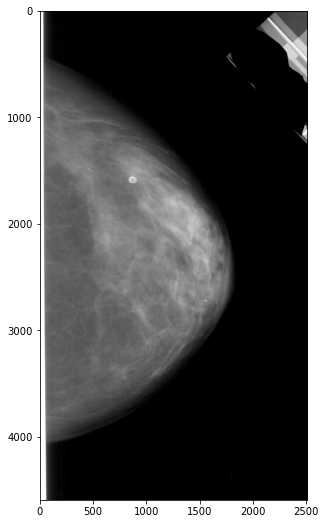

In [122]:
img = "../../data/cbis-ddsm/all_test_img/" + fp_df_ruler["Subject ID"].iloc[10] + ".png"
img_arr = imread(img, cv2.IMREAD_UNCHANGED)
#resized_img = read_resize_img(img, target_size=(1152, 896), target_scale=target_scale)
#img_arr[img_arr == 0] = 1
plt.imshow(img_arr, cmap="gray")

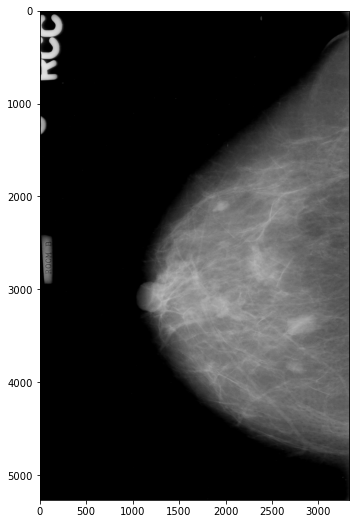

In [123]:
img = "../../data/cbis-ddsm/all_test_img/" + fp_df_text["Subject ID"].iloc[31] + ".png"
img_arr = imread(img, cv2.IMREAD_UNCHANGED)
#resized_img = read_resize_img(img, target_size=(1152, 896), target_scale=target_scale)
#img_arr[img_arr == 0] = 1
plt.imshow(img_arr, cmap="gray")

### FP Text

Calc-Test_P_02153_RIGHT_CC
(928, (1188, 928))
(928, (1188, 928))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


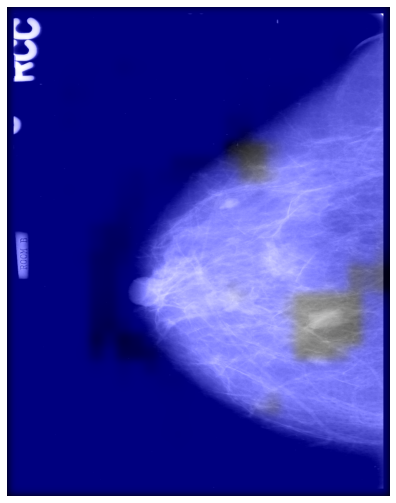

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


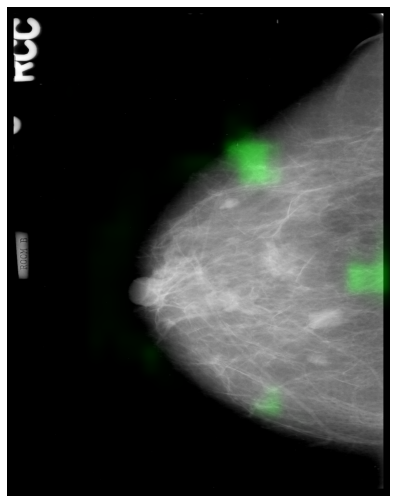

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


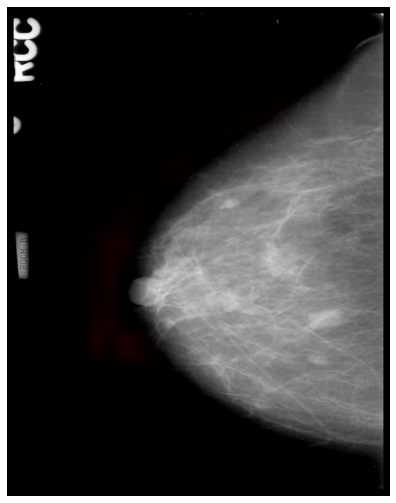

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


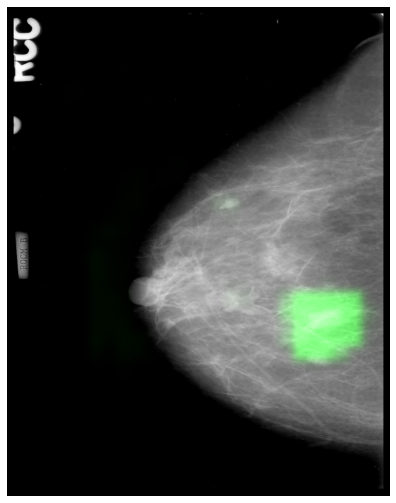

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


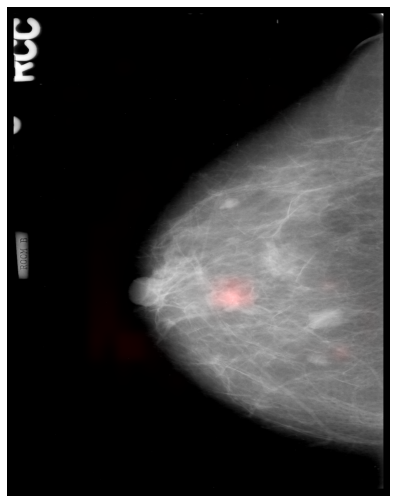

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


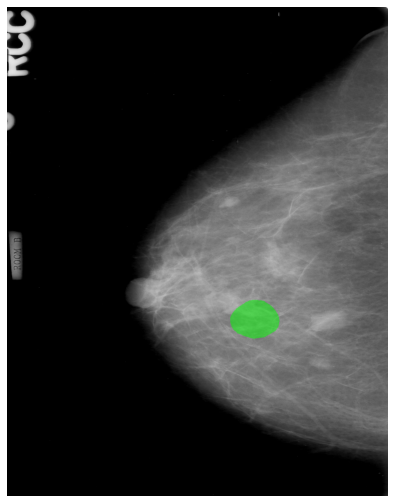

In [124]:
subject_id = fp_df_text["Subject ID"].iloc[31]
print(subject_id)
get_heatmap(subject_id)

### FP Nipple Marker

Calc-Test_P_00100_RIGHT_CC
(928, (1188, 928))
(928, (1188, 928))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


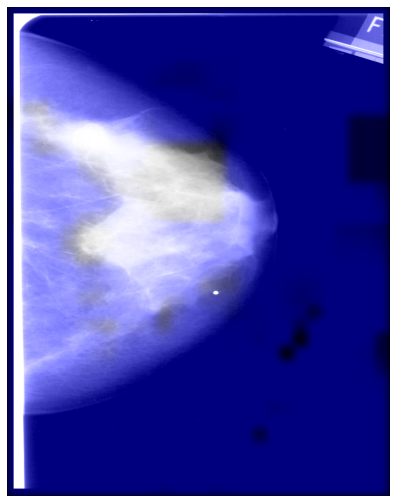

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


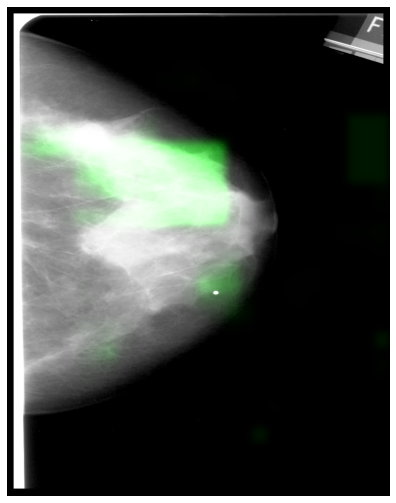

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


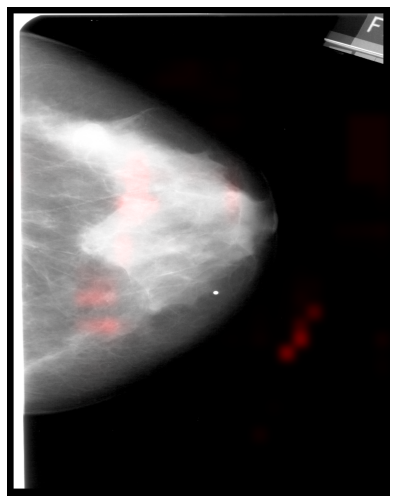

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


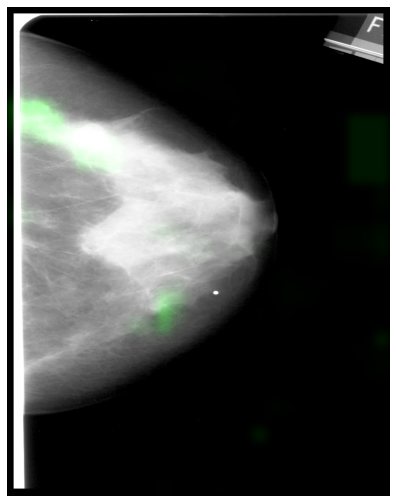

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


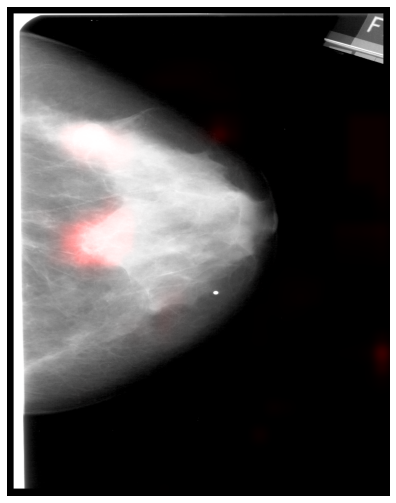

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


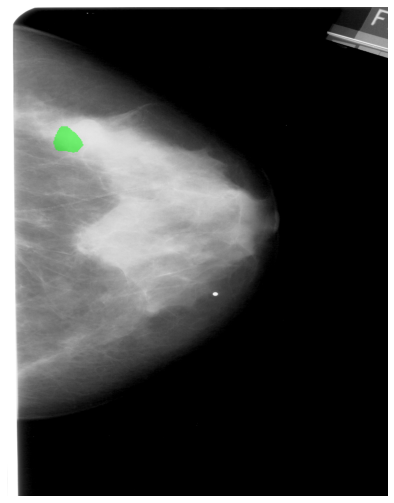

In [125]:
subject_id = fp_df_nipple["Subject ID"].iloc[1]
print(subject_id)
get_heatmap(subject_id)

### FP Scar Marker

Calc-Test_P_00579_LEFT_MLO
(928, (1188, 928))
(928, (1188, 928))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


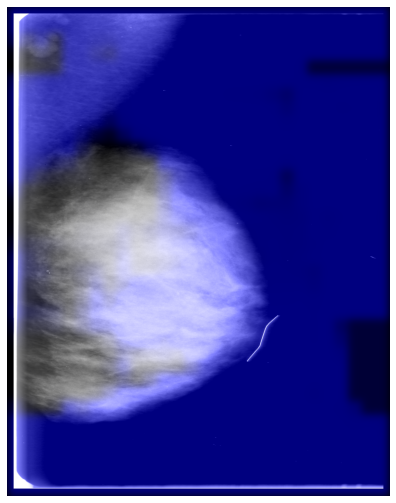

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


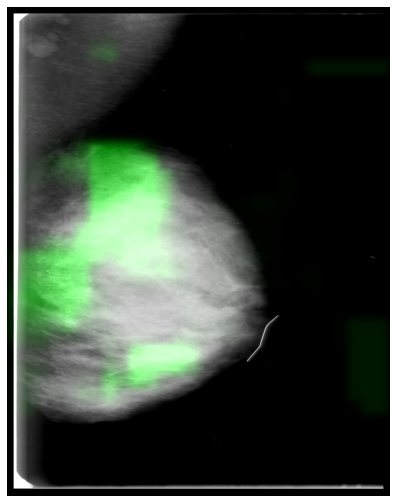

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


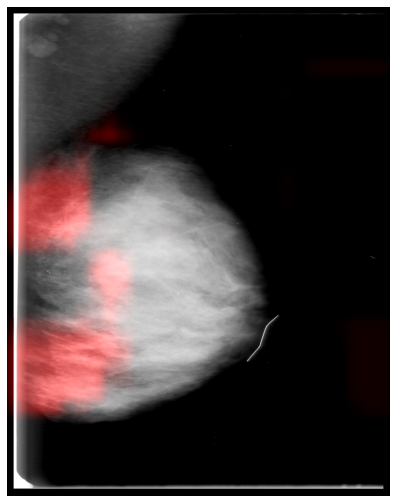

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


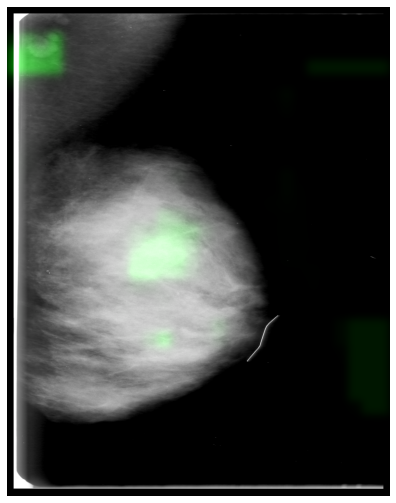

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


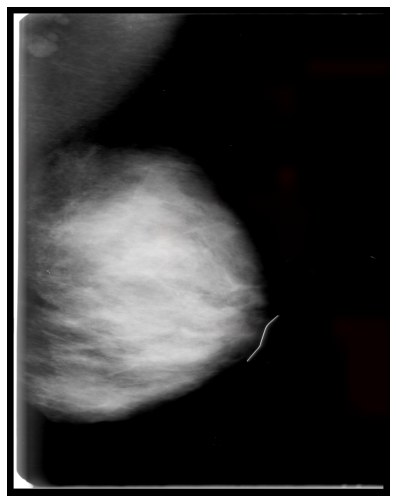

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


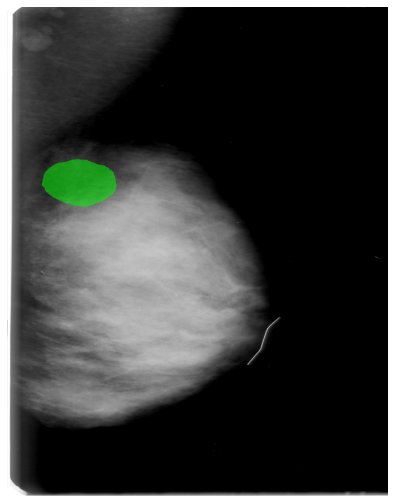

In [126]:
subject_id = fp_df_scar["Subject ID"].iloc[0]
print(subject_id)
get_heatmap(subject_id)

### FP Ruler

Calc-Test_P_01845_RIGHT_CC
(928, (1188, 928))
(928, (1188, 928))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


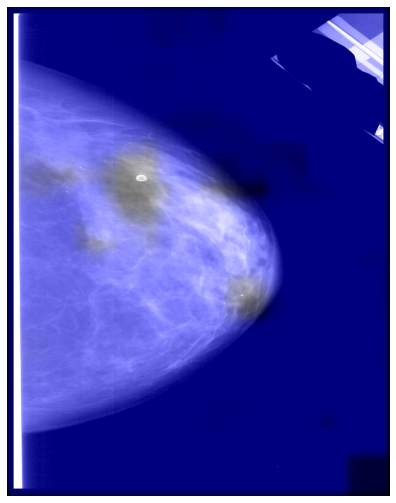

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


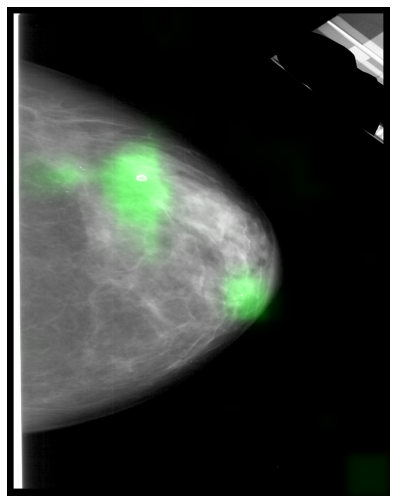

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


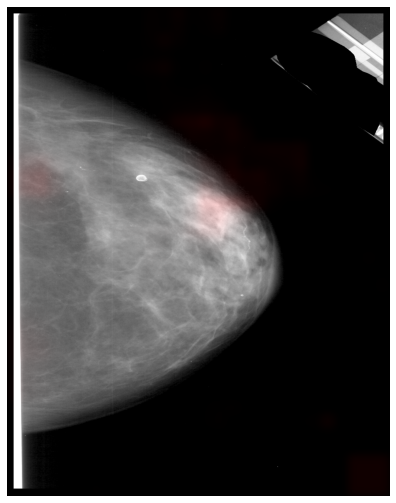

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


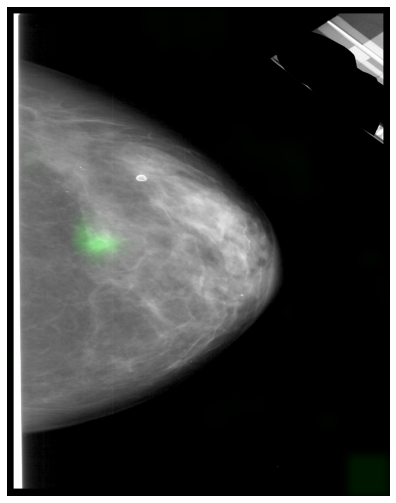

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


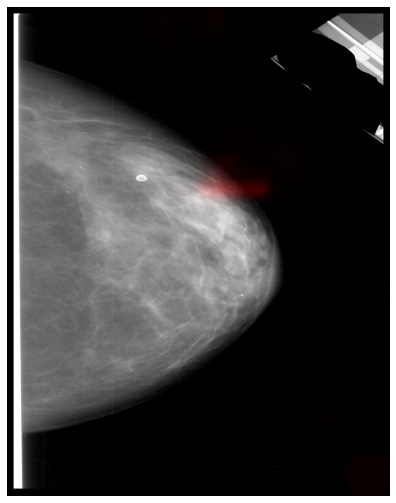

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


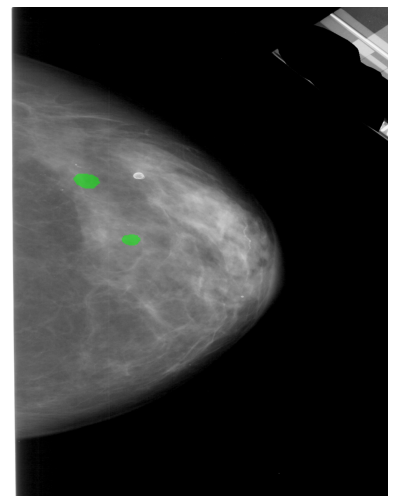

In [127]:
subject_id = fp_df_ruler["Subject ID"].iloc[10]
print(subject_id)
get_heatmap(subject_id)

# False negatives

In [ ]:
img = "../../data/cbis-ddsm/all_test_img/" + fn_df_text["Subject ID"].iloc[0] + ".png"
img_arr = imread(img, cv2.IMREAD_UNCHANGED)
#resized_img = read_resize_img(img, target_size=(1152, 896), target_scale=target_scale)
#img_arr[img_arr == 0] = 1
plt.imshow(img_arr, cmap="gray")

In [ ]:
subject_id = fn_df_text["Subject ID"].iloc[0]
print(subject_id)
get_heatmap(subject_id)

In [ ]:
subject_id = fn_df_nipple["Subject ID"].iloc[0]
print(subject_id)
get_heatmap(subject_id)

In [ ]:
subject_id = fn_df_scar["Subject ID"].iloc[0]
print(subject_id)
get_heatmap(subject_id)

In [ ]:
subject_id = fn_df_ruler["Subject ID"].iloc[0]
print(subject_id)
get_heatmap(subject_id)